In [1]:
from skimage import img_as_uint, img_as_ubyte, img_as_bool, img_as_float
from skimage.io import imread, imshow, imsave, find_available_plugins
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.viewer import ImageViewer
from skimage.filters import try_all_threshold, gabor, threshold_otsu, threshold_mean, threshold_minimum, \
threshold_local, frangi, gaussian  
from skimage.morphology import skeletonize, skeletonize_3d, thin, disk
from skimage.util import invert
from skimage.feature import canny, orb
from skimage.filters.rank import enhance_contrast, autolevel
from skimage.segmentation import felzenszwalb
from PIL import Image, ImageDraw
import shutil 
import cv2 as cv
import os
import numpy as np
#sns.set(style='whitegrid')
import json

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = {'png', 'retina'}

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
%matplotlib inline

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


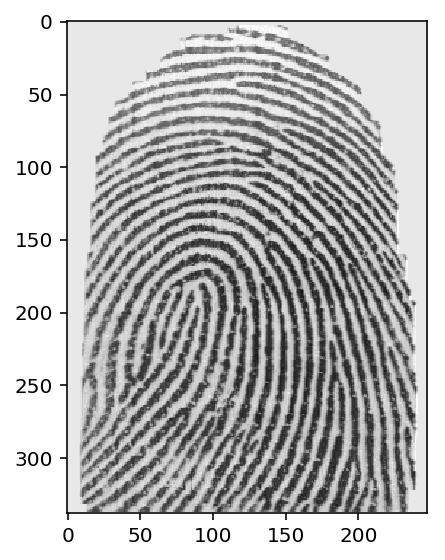

In [3]:
img = imread("data/raw_data/png/1_8.png", as_grey = True)
imshow(img)

In [4]:
# im = cv.imread('data/raw_data/png/1_8.png', 0)
# # contours, hierarchy = cv.findContours(im.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
# # out = np.zeros_like(im)
# # cv.drawContours(out, contours, -1, 255, 3)
# # cv.imshow('Output Contour', out)
# contours = cv.findContours(im, storage, mode=CV_RETR_EXTERNAL, method=CV_CHAIN_APPROX_SIMPLE, offset=(0, 0))
# cv.imshow(contours)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


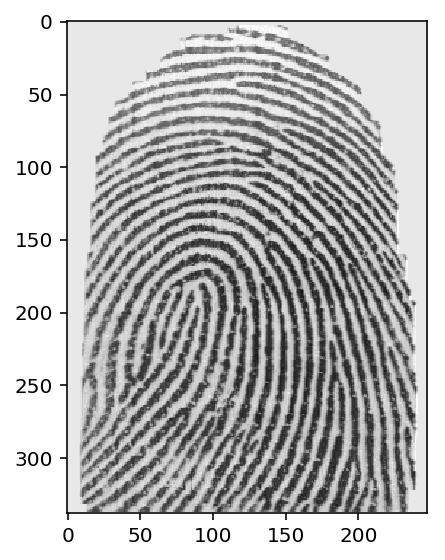

In [5]:
img_intensity_scale = rescale_intensity(img, in_range= "dtype")

imshow(img_intensity_scale)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


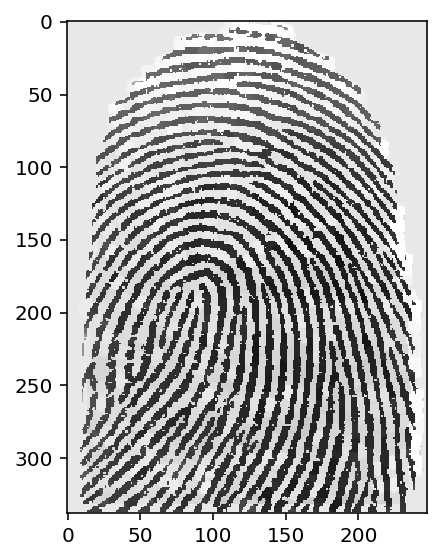

In [6]:
img_enhanced_contrast = enhance_contrast(img_intensity_scale, disk(5))

imshow(img_enhanced_contrast)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


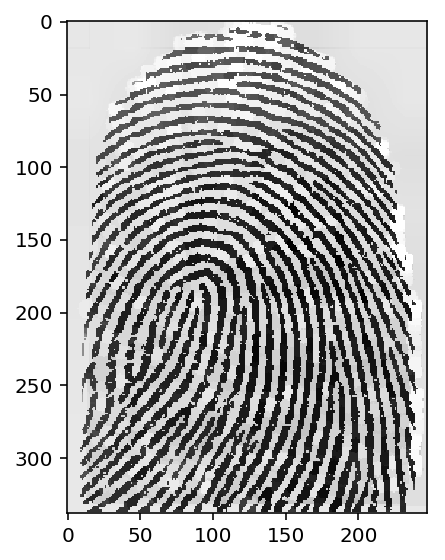

In [7]:
img_equalized = equalize_adapthist(img_enhanced_contrast, clip_limit= 0.01)
imshow(img_equalized)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


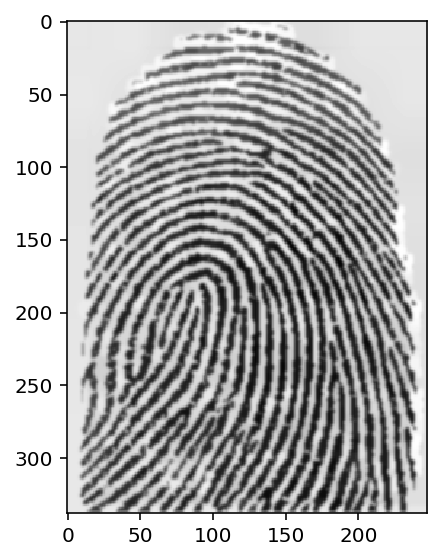

In [8]:
img_smoothed = gaussian(img_equalized)

imshow(img_smoothed)

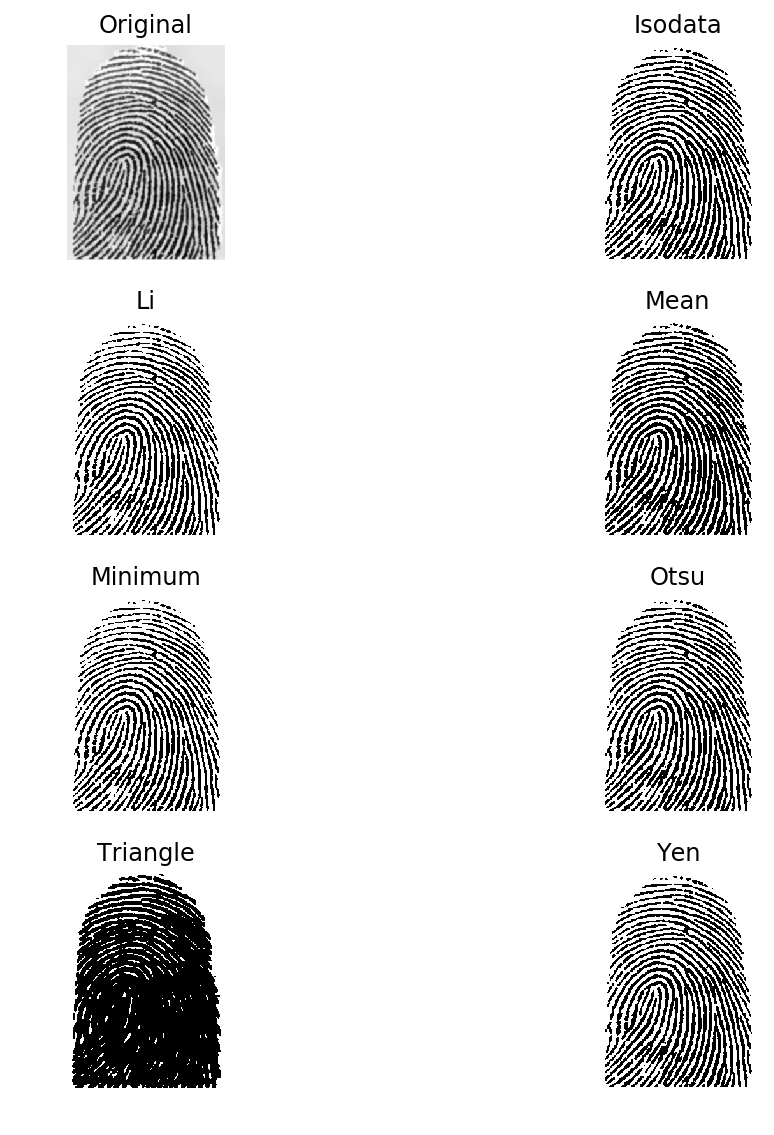

In [9]:
fig, ax = try_all_threshold(img_smoothed, figsize=(10, 8), verbose=False)
plt.show()

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


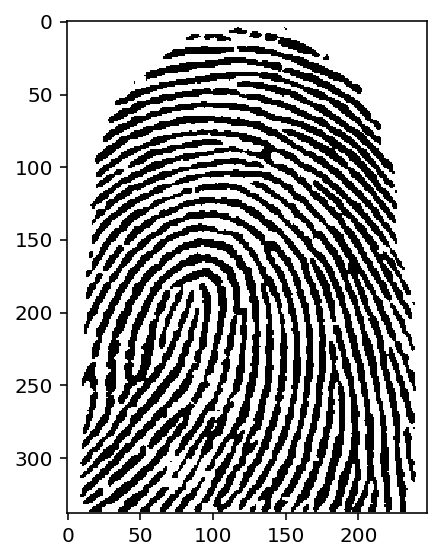

In [10]:
thresh_local = threshold_local(img_smoothed, 125, 'mean', mode = "reflect")
img_binarized = img_smoothed > thresh_local

imshow(img_binarized)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


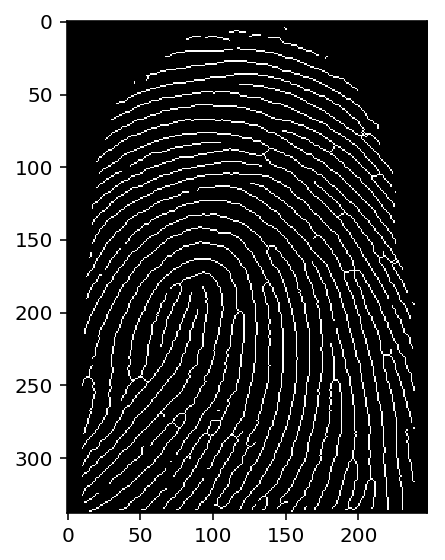

In [11]:
img_thinned = thin(invert(img_binarized))

imshow(img_thinned)

In [12]:
from verify import run_simulation, load_config
from core import match
import collections

import pandas as pd
import numpy as np

def compute_match_scores(results, threshold):
    match_scores = [1 if raw_score >= threshold else 0 for raw_score in results.scores]
    return match_scores

def compute_FNMR(match_scores):
    FNMR = 100-compute_FMR(match_scores)
    return FNMR

def compute_FMR(match_scores):
    FMR = (float(sum(match_scores))/(len(match_scores)))*100
    return FMR

def compute_TNMR(FMR):
    
    TNMR_rates = []
    for i in FMR:
        TNMR = 1 - i
        TNMR_rates.append(TNMR)
        #     TMR = (float(sum(match_scores))/(len(match_scores)))*100
    return TNMR_rates

def compute_TMR(FNMR):
    
    TMR_rates = []
    for i in FNMR:
        TMR = 1 - i
        TMR_rates.append(TMR)
        #     TMR = (float(sum(match_scores))/(len(match_scores)))*100
    return TMR_rates


if __name__=="__main__":
    config = load_config()
    db = config["db"]

    #genuine_results = run_simulation(matcher, db, True)
    #fraud_results = run_simulation(matcher, db, False)
    genuine_results = pd.read_csv("results/results_png_genuine.csv",sep='\t', index_col = 0)
    fraud_results = pd.read_csv("results/results_png_fraud.csv",sep='\t', index_col = 0)
    
    thresholds = [round(thresh,2) for thresh in np.arange(0.0, 1.01, 0.01)]
    FNMR_rates= []
    FMR_rates= []
    for threshold in thresholds:
        match_scores = [compute_match_scores(results,threshold) for results in [genuine_results,fraud_results]]
        FNMR_rates.append(compute_FNMR(match_scores[0]))
        FMR_rates.append(compute_FMR(match_scores[1]))
    TMR_var=compute_TMR(FNMR_rates)
    TNMR_var=compute_TNMR(FMR_rates)
print(TMR_var)
print("/n")
print(TNMR_var)





[0.1071428571428612, 0.1071428571428612, 0.1071428571428612, 0.1071428571428612, 0.1071428571428612, -0.7857142857142918, -0.7857142857142918, -0.7857142857142918, -0.7857142857142918, -0.7857142857142918, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -1.6785714285714306, -2.5714285714285694, -3.464285714285708, -3.464285714285708, -4.357142857142861, -4.357142857142861, -4.357142857142861, -4.357142857142861, -4.357142857142861, -4.357142857142861, -4.357142857142861, -5.25, -5.25, -7.928571428571431, -8.82142857142857, -10.607142857142861, -10.607142857142861, -10.607142857142861, -11.5, -12.392857142857139, -12.392857142857139, -12.392857142857139, -13.285714285714292, -14.17857142857143, -14.17857142857143, -14.17857142857143, -15.07142857142857, -16.85714285714286, -16.85714285714286, -17.75, -17.75, -17.75, -17.75, -18.64285714285714, -21.32142857142857, -23.10714285714286, -23.10

In [13]:
df = pd.DataFrame({"threshold":thresholds,"FNMR":FNMR_rates,"FMR":FMR_rates, "TNMR":TNMR_var, "TMR":TMR_var })
df.head()

,FMR,FNMR,TMR,TNMR,threshold
0,82.142857,0.892857,0.107143,-81.142857,0.00
1,82.142857,0.892857,0.107143,-81.142857,0.01
2,82.142857,0.892857,0.107143,-81.142857,0.02
3,82.142857,0.892857,0.107143,-81.142857,0.03
4,80.357143,0.892857,0.107143,-79.357143,0.04


In [14]:
poly_1 = np.polyfit(df.threshold, df.FMR, deg=2)
poly_2 = np.polyfit(df.threshold, df.FNMR, deg=2)

df["FMR_fitted"]  = np.polyval(poly_1, df.threshold)
df["FNMR_fitted"]  = np.polyval(poly_2, df.threshold)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


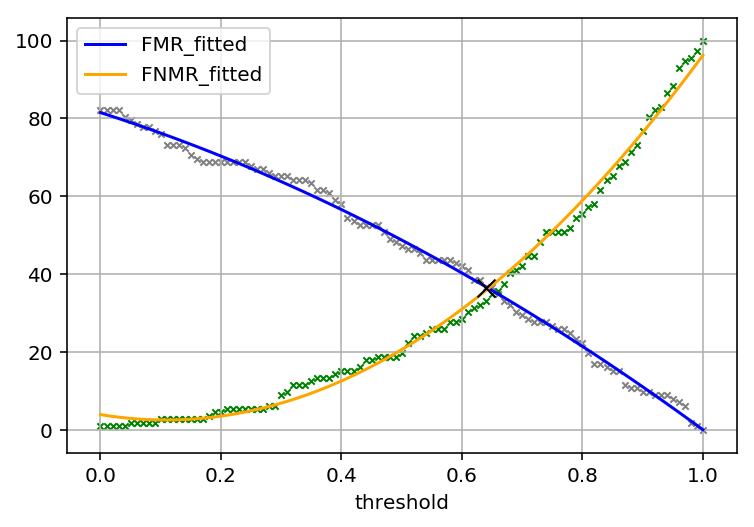

In [15]:
df.plot(x="threshold",y =["FMR_fitted","FNMR_fitted"], kind='line', grid = True, color = ["blue","orange"])
plt.scatter(df["threshold"], df["FMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='grey')
plt.scatter(df["threshold"], df["FNMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='green')

plt.scatter(x = 0.64, y = 36.5, marker='x', s=80, zorder=5, 
            linewidth=1, color='black')

In [16]:
poly_3 = np.polyfit(df.threshold, df.TMR, deg=2)
poly_4 = np.polyfit(df.threshold, df.TNMR, deg=2)

df["TMR_fitted"]  = np.polyval(poly_3, df.threshold)
df["TNMR_fitted"]  = np.polyval(poly_4, df.threshold)

/Users/siddhant/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


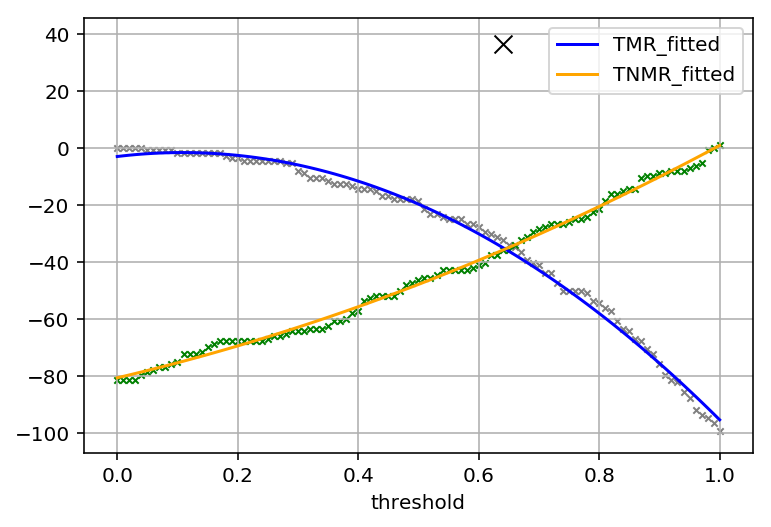

In [17]:
df.plot(x="threshold",y =["TMR_fitted","TNMR_fitted"], kind='line', grid = True, color = ["blue","orange"])
plt.scatter(df["threshold"], df["TMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='grey')
plt.scatter(df["threshold"], df["TNMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='green')

plt.scatter(x = 0.64, y = 36.5, marker='x', s=80, zorder=5, 
            linewidth=1, color='black')